In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *
from src.plotting import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple
import wandb 
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

In [93]:
env = gym.make('CartPole-v0')
# env.observation_space.low[1] = -3.4
# env.observation_space.low[3] = -3.4
# env.observation_space.high[1] = 3.4
# env.observation_space.high[3] = 3.4
print('State Space ', env.observation_space) # Cart position, cart velocity, pole angle, pole velocity
print(' * Low ', env.observation_space.low)
print(' * High ', env.observation_space.high)
print('State Space sample', env.observation_space.sample())
print('Action Space ', env.action_space)


State Space  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
 * Low  [-4.800e+00 -3.403e+38 -4.189e-01 -3.403e+38]
 * High  [4.800e+00 3.403e+38 4.189e-01 3.403e+38]
State Space sample [-3.890e+00  2.155e+38 -3.110e-01 -2.954e+38]
Action Space  Discrete(2)


In [94]:
buckets = (0, 0, 6, 12)
upper_bounds = [env.observation_space.high[0], 3.4, env.observation_space.high[2], 3.4]
lower_bounds = [env.observation_space.low[0], -3.4, env.observation_space.low[2], -3.4]
state_length = len(lower_bounds)

In [150]:
state = env.reset()

In [149]:
env.observation_space.high[2]

0.41887903

In [152]:
state

array([ 0.042,  0.01 , -0.023, -0.026])

In [145]:
state, reward, done, info = env.step(0)
ratios = [(state[i] + abs(lower_bounds[i])) / (abs(upper_bounds[i]) - lower_bounds[i]) for i in range(state_length)]
reduced_state = [int((buckets[i] - 1) * ratios[i]) for i in range(state_length)]
reduced_state

[0, 0, 14, 19]

In [167]:
env = gym.make('CartPole-v0')
state_size = (1, 1, 10, 10)

env.observation_space.low[1] = -3.4
env.observation_space.low[3] = -3.4
env.observation_space.high[1] = 3.4
env.observation_space.high[3] = 3.4

env = DiscretizationWrapper(env, state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 4, 
    "e_w":0.05, 
    "e_n":0.005, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 200
}

In [165]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/500, Reward 20.0, Average Max Reward: 25.0, Total steps 20.0, Epsilon: 0.72, Alpha: 0.10, Time 0.002
Episode 100/500, Reward 55.0, Average Max Reward: 48.1, Total steps 55.0, Epsilon: 0.54, Alpha: 0.10, Time 0.004
Episode 150/500, Reward 59.0, Average Max Reward: 54.6, Total steps 59.0, Epsilon: 0.37, Alpha: 0.10, Time 0.004
Episode 200/500, Reward 68.0, Average Max Reward: 41.7, Total steps 68.0, Epsilon: 0.19, Alpha: 0.10, Time 0.004
Episode 250/500, Reward 236.0, Average Max Reward: 119.5, Total steps 236.0, Epsilon: 0.01, Alpha: 0.10, Time 0.013
Episode 300/500, Reward 209.0, Average Max Reward: 167.4, Total steps 209.0, Epsilon: 0.01, Alpha: 0.10, Time 0.011
Episode 350/500, Reward 256.0, Average Max Reward: 152.9, Total steps 256.0, Epsilon: 0.01, Alpha: 0.10, Time 0.014
Episode 400/500, Reward 117.0, Average Max Reward: 163.2, Total steps 117.0, Epsilon: 0.01, Alpha: 0.10, Time 0.006
Episode 450/500, Reward 137.0, Average Max Reward: 169.9, Total steps 137.0, Epsilon:

In [171]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))

act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255


#### Starting training #####
Episode 50/500, Average Max Reward: 21.57, Global Error: 1.90, Total steps 12.0, Discount: -0.03, Time 0.070
	 MLGNG nodes per action layer: 2 1
Episode 100/500, Average Max Reward: 102.65, Global Error: 0.79, Total steps 141.0, Discount: -0.05, Time 0.185
	 MLGNG nodes per action layer: 10 10
Episode 150/500, Average Max Reward: 188.04, Global Error: 0.48, Total steps 219.0, Discount: 0.08, Time 0.255
	 MLGNG nodes per action layer: 10 10
Episode 200/500, Average Max Reward: 183.65, Global Error: 0.15, Total steps 212.0, Discount: 0.09, Time 0.259
	 MLGNG nodes per action layer: 10 9
Episode 250/500, Average Max Reward: 190.29, Global Error: 0.37, Total steps 188.0, Discount: -0.02, Time 0.240
	 MLGNG nodes per action layer: 10 8
Episode 300/500, Average Max Reward: 202.10, Global Error: 4.17, Total steps 212.0, Discount: 0.11, Time 0.306
	 MLGNG nodes per action layer: 8 4
Episode 350/500, Average Max Reward: 199.78, Global Error: 1.41, Total steps 175.0,

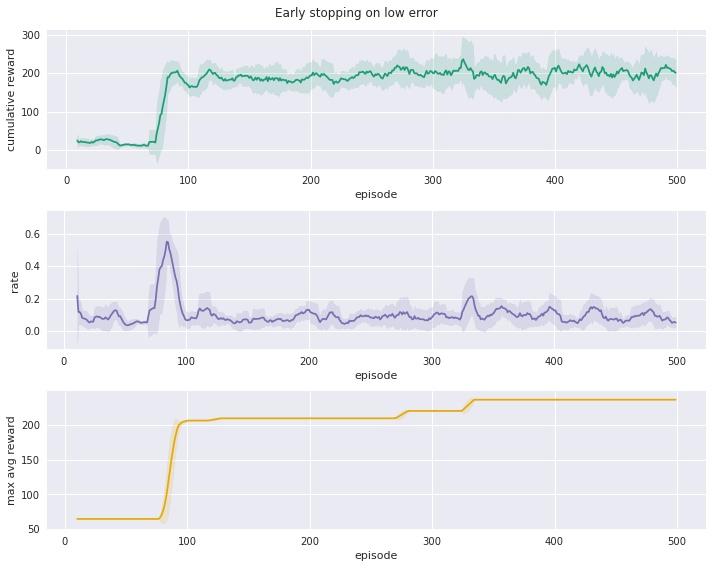

In [172]:
stats = {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "global_error":     np.zeros((num_episodes, env.action_space.n)),
        "mlgng_nodes":      [],
        "best_actions":     [],
        "nodes": np.zeros((num_episodes, env.action_space.n)),
        "rate": np.zeros(num_episodes),
        "max_avg_reward": np.zeros(num_episodes),
}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)

conrl.train(env=env, stats=stats, num_episodes=500, print_freq=50)

to_plot = ["cumulative_reward", "rate", "max_avg_reward"]

stats_to_plot = {key: value for key, value in stats.items() if key in to_plot}
# stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
# stats_to_plot["nodes"] = stats_to_plot["nodes"].sum(axis=1)

plot_stats(stats_to_plot, figsize=(10, 8), title="Early stopping on low error")

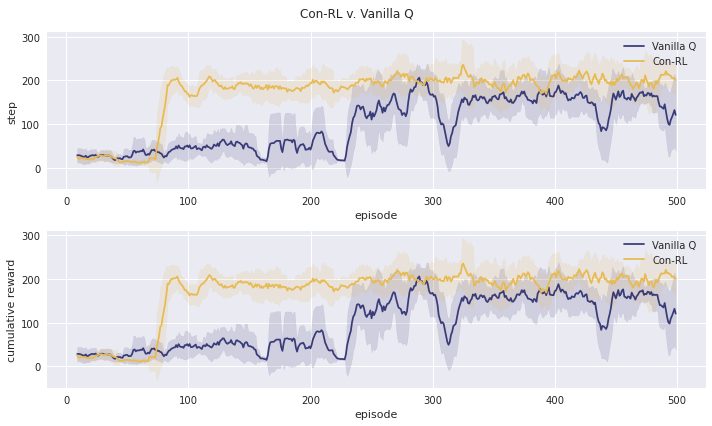

In [174]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats.items() if key in to_plot}
},
title="Con-RL v. Vanilla Q",
rolling_window=10)

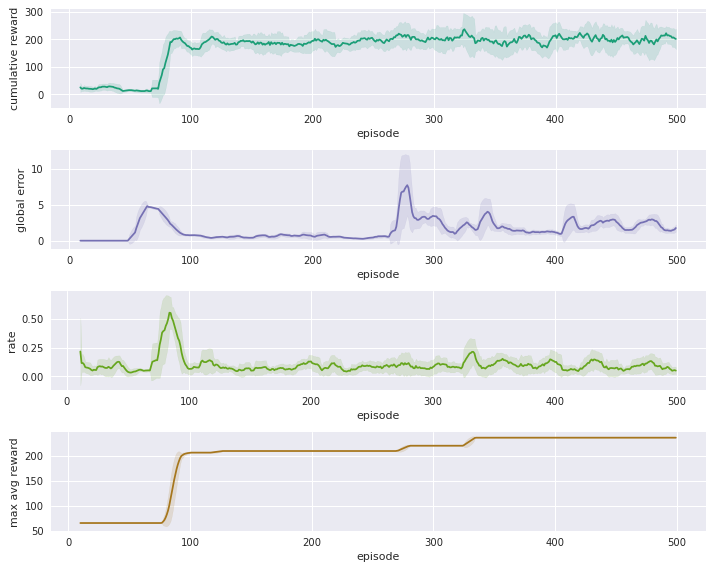

In [173]:
to_plot = ["cumulative_reward", "rate", "max_avg_reward", "global_error"]

stats_to_plot = {key: value for key, value in stats.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
# stats_to_plot["nodes"] = stats_to_plot["nodes"].sum(axis=1)

plot_stats(stats_to_plot, figsize=(10, 8))

In [175]:
plot_nodes_changes(stats["mlgng_nodes"], 
                rewards=stats["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)

ValueError: too many values to unpack (expected 3)

In [139]:
plot_nodes_changes(stats["mlgng_nodes"], 
                rewards=stats["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)

In [16]:
with (open("./src/experiments/base.p", "rb")) as openfile:
    base_exp = pickle.load(openfile)

with (open("./src/experiments/node_perturbed_addition.p", "rb")) as openfile:
    perturbed_exp = pickle.load(openfile)

In [20]:
plot_nodes_changes(base_exp[0]["mlgng_nodes"], 
                rewards=base_exp[0]["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(perturbed_exp[0]["mlgng_nodes"], 
                rewards=perturbed_exp[0]["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)

In [ ]:
# to_plot = ["step", "cumulative_reward"]
# plot_stats_comparison({
#     "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
#     "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
# },
# title="Con-RL v. Vanilla Q",
# rolling_window=10)